In [ ]:
pip install torch

In [ ]:
pip install torchvision

In [ ]:
pip install --upgrade bottleneck

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Cell 1: Imports and Setup
import os
import numpy as np
from PIL import Image
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
from torchvision import models, transforms
from torchvision.datasets import ImageFolder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm

In [ ]:
# Set up device (CPU or GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# Data directory
data_dir = '/content/drive/MyDrive/eardrumDs'


In [ ]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load all data
dataset = ImageFolder(data_dir, transform=transform)
print(f"Number of classes: {len(dataset.classes)}")
print(f"Classes: {dataset.classes}")

Number of classes: 3
Classes: ['Aom', 'Chornic', 'Normal']


In [ ]:
# Split the dataset
train_dataset, test_dataset = train_test_split(dataset, test_size=0.2, random_state=42)
train_dataset, val_dataset = train_test_split(train_dataset, test_size=0.25, random_state=42)

In [ ]:
# Create DataLoaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=32)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Training samples: 429
Validation samples: 143
Test samples: 144


In [ ]:
# Initialize models
vgg_model = models.vgg16(pretrained=True)
vgg_model.classifier[-1] = nn.Linear(vgg_model.classifier[-1].in_features, len(dataset.classes))
vgg_model.to(device)

resnet_model = models.resnet50(pretrained=True)
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(dataset.classes))
resnet_model.to(device)

densenet_model = models.densenet121(pretrained=True)
densenet_model.classifier = nn.Linear(densenet_model.classifier.in_features, len(dataset.classes))
densenet_model.to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
 

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [ ]:
def train_model(model, optimizer, criterion, num_epochs=20):
    best_f1 = 0.0
    history = {
        'train_loss': [], 'train_acc': [],
        'val_loss': [], 'val_f1': []
    }

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        running_corrects = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for inputs, labels in pbar:
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, preds = torch.max(outputs, 1)
            running_corrects += torch.sum(preds == labels.data)

            pbar.set_postfix({'loss': loss.item()})

        epoch_loss = running_loss / len(train_dataset)
        epoch_acc = running_corrects.double() / len(train_dataset)

        # Validation phase
        model.eval()
        val_loss = 0.0
        y_true = []
        y_pred = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs = inputs.to(device)
                labels = labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * inputs.size(0)
                _, preds = torch.max(outputs, 1)
                y_true.extend(labels.cpu().numpy())
                y_pred.extend(preds.cpu().numpy())

        val_loss = val_loss / len(val_dataset)
        val_f1 = f1_score(y_true, y_pred, average='macro')

        # Save metrics
        history['train_loss'].append(epoch_loss)
        history['train_acc'].append(epoch_acc.item())
        history['val_loss'].append(val_loss)
        history['val_f1'].append(val_f1)

        print(f'Epoch {epoch+1}/{num_epochs}:')
        print(f'Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}')
        print(f'Val Loss: {val_loss:.4f}, Val F1: {val_f1:.4f}')

        if val_f1 > best_f1:
            best_f1 = val_f1
            torch.save(model.state_dict(), f"{model.__class__.__name__}_best.pth")

    return model, history

In [ ]:
# Train VGG16
print("Training VGG16...")
vgg_optimizer = optim.Adam(vgg_model.parameters(), lr=1e-4)
vgg_criterion = nn.CrossEntropyLoss()
trained_vgg, vgg_history = train_model(vgg_model, vgg_optimizer, vgg_criterion)

# Train ResNet50
print("\nTraining ResNet50...")
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=1e-4)
resnet_criterion = nn.CrossEntropyLoss()
trained_resnet, resnet_history = train_model(resnet_model, resnet_optimizer, resnet_criterion)

# Train DenseNet121
print("\nTraining DenseNet121...")
densenet_optimizer = optim.Adam(densenet_model.parameters(), lr=1e-4)
densenet_criterion = nn.CrossEntropyLoss()
trained_densenet, densenet_history = train_model(densenet_model, densenet_optimizer, densenet_criterion)

Training VGG16...


Epoch 1/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 0.7518, Train Acc: 0.7156
Val Loss: 0.5110, Val F1: 0.2913


Epoch 2/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.6255, Train Acc: 0.7669
Val Loss: 0.4779, Val F1: 0.2913


Epoch 3/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.4158, Train Acc: 0.8065
Val Loss: 0.4507, Val F1: 0.7256


Epoch 4/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.2324, Train Acc: 0.9044
Val Loss: 0.5819, Val F1: 0.7245


Epoch 5/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.2192, Train Acc: 0.9207
Val Loss: 0.7021, Val F1: 0.7166


Epoch 6/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 0.2226, Train Acc: 0.9301
Val Loss: 0.9387, Val F1: 0.5145


Epoch 7/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 0.3551, Train Acc: 0.8368
Val Loss: 0.4902, Val F1: 0.7323


Epoch 8/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 0.1495, Train Acc: 0.9697
Val Loss: 0.5044, Val F1: 0.7990


Epoch 9/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 0.1549, Train Acc: 0.9650
Val Loss: 0.7511, Val F1: 0.7248


Epoch 10/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 0.1166, Train Acc: 0.9604
Val Loss: 0.4663, Val F1: 0.7385


Epoch 11/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 0.0518, Train Acc: 0.9767
Val Loss: 0.5667, Val F1: 0.7735


Epoch 12/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 0.0342, Train Acc: 0.9860
Val Loss: 0.6588, Val F1: 0.7525


Epoch 13/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 0.0180, Train Acc: 0.9930
Val Loss: 0.7938, Val F1: 0.8033


Epoch 14/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 0.0100, Train Acc: 0.9930
Val Loss: 0.8174, Val F1: 0.7887


Epoch 15/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 0.0093, Train Acc: 0.9930
Val Loss: 0.9580, Val F1: 0.7806


Epoch 16/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 0.0081, Train Acc: 0.9930
Val Loss: 0.9196, Val F1: 0.7806


Epoch 17/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 0.0075, Train Acc: 0.9930
Val Loss: 0.8957, Val F1: 0.7591


Epoch 18/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 0.0065, Train Acc: 0.9977
Val Loss: 0.8900, Val F1: 0.7861


Epoch 19/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 0.0088, Train Acc: 0.9907
Val Loss: 0.8906, Val F1: 0.7861


Epoch 20/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 0.0075, Train Acc: 0.9953
Val Loss: 0.8899, Val F1: 0.7861

Training ResNet50...


Epoch 1/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 0.8181, Train Acc: 0.6270
Val Loss: 0.4942, Val F1: 0.4118


Epoch 2/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.2582, Train Acc: 0.9091
Val Loss: 0.3679, Val F1: 0.7707


Epoch 3/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.0586, Train Acc: 0.9860
Val Loss: 0.3541, Val F1: 0.8168


Epoch 4/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.0322, Train Acc: 0.9883
Val Loss: 0.3814, Val F1: 0.7763


Epoch 5/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.0442, Train Acc: 0.9860
Val Loss: 0.4191, Val F1: 0.7271


Epoch 6/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 0.0438, Train Acc: 0.9860
Val Loss: 0.4550, Val F1: 0.7873


Epoch 7/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 0.0346, Train Acc: 0.9930
Val Loss: 0.5293, Val F1: 0.7406


Epoch 8/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 0.0317, Train Acc: 0.9907
Val Loss: 0.5598, Val F1: 0.7461


Epoch 9/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 0.0319, Train Acc: 0.9860
Val Loss: 0.5094, Val F1: 0.7166


Epoch 10/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 0.0593, Train Acc: 0.9767
Val Loss: 0.5245, Val F1: 0.6981


Epoch 11/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 0.1113, Train Acc: 0.9720
Val Loss: 0.6744, Val F1: 0.6554


Epoch 12/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 0.0586, Train Acc: 0.9837
Val Loss: 0.3868, Val F1: 0.7991


Epoch 13/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 0.0493, Train Acc: 0.9814
Val Loss: 0.4881, Val F1: 0.7413


Epoch 14/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 0.0286, Train Acc: 0.9860
Val Loss: 0.4760, Val F1: 0.7739


Epoch 15/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 0.0335, Train Acc: 0.9860
Val Loss: 0.4117, Val F1: 0.8143


Epoch 16/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 0.0232, Train Acc: 0.9930
Val Loss: 0.4800, Val F1: 0.7704


Epoch 17/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 0.0145, Train Acc: 0.9930
Val Loss: 0.5008, Val F1: 0.7630


Epoch 18/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 0.0116, Train Acc: 0.9930
Val Loss: 0.5572, Val F1: 0.7094


Epoch 19/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 0.0249, Train Acc: 0.9837
Val Loss: 0.6013, Val F1: 0.7316


Epoch 20/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 0.0131, Train Acc: 0.9953
Val Loss: 0.5222, Val F1: 0.7873

Training DenseNet121...


Epoch 1/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 1/20:
Train Loss: 0.7541, Train Acc: 0.7226
Val Loss: 0.5366, Val F1: 0.3933


Epoch 2/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 2/20:
Train Loss: 0.2968, Train Acc: 0.9417
Val Loss: 0.4492, Val F1: 0.5987


Epoch 3/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 3/20:
Train Loss: 0.1374, Train Acc: 0.9930
Val Loss: 0.4203, Val F1: 0.6740


Epoch 4/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 4/20:
Train Loss: 0.0703, Train Acc: 0.9930
Val Loss: 0.3695, Val F1: 0.7565


Epoch 5/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 5/20:
Train Loss: 0.0490, Train Acc: 0.9907
Val Loss: 0.4064, Val F1: 0.6665


Epoch 6/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 6/20:
Train Loss: 0.0403, Train Acc: 0.9953
Val Loss: 0.3799, Val F1: 0.7626


Epoch 7/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 7/20:
Train Loss: 0.0489, Train Acc: 0.9860
Val Loss: 0.3824, Val F1: 0.7790


Epoch 8/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 8/20:
Train Loss: 0.0446, Train Acc: 0.9907
Val Loss: 0.3597, Val F1: 0.7855


Epoch 9/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 9/20:
Train Loss: 0.0287, Train Acc: 0.9930
Val Loss: 0.3674, Val F1: 0.7622


Epoch 10/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 10/20:
Train Loss: 0.0285, Train Acc: 0.9977
Val Loss: 0.4016, Val F1: 0.7223


Epoch 11/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 11/20:
Train Loss: 0.0458, Train Acc: 0.9814
Val Loss: 0.3499, Val F1: 0.7385


Epoch 12/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 12/20:
Train Loss: 0.0260, Train Acc: 0.9930
Val Loss: 0.3959, Val F1: 0.7734


Epoch 13/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 13/20:
Train Loss: 0.0245, Train Acc: 0.9930
Val Loss: 0.4158, Val F1: 0.7826


Epoch 14/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 14/20:
Train Loss: 0.0195, Train Acc: 0.9953
Val Loss: 0.4211, Val F1: 0.7413


Epoch 15/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 15/20:
Train Loss: 0.0136, Train Acc: 0.9953
Val Loss: 0.4471, Val F1: 0.7281


Epoch 16/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 16/20:
Train Loss: 0.0152, Train Acc: 0.9953
Val Loss: 0.4664, Val F1: 0.6768


Epoch 17/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 17/20:
Train Loss: 0.0169, Train Acc: 0.9930
Val Loss: 0.4393, Val F1: 0.7548


Epoch 18/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 18/20:
Train Loss: 0.0140, Train Acc: 0.9930
Val Loss: 0.4009, Val F1: 0.7928


Epoch 19/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 19/20:
Train Loss: 0.0256, Train Acc: 0.9883
Val Loss: 0.4040, Val F1: 0.7762


Epoch 20/20:   0%|          | 0/14 [00:00<?, ?it/s]

Epoch 20/20:
Train Loss: 0.0190, Train Acc: 0.9953
Val Loss: 0.4767, Val F1: 0.7385


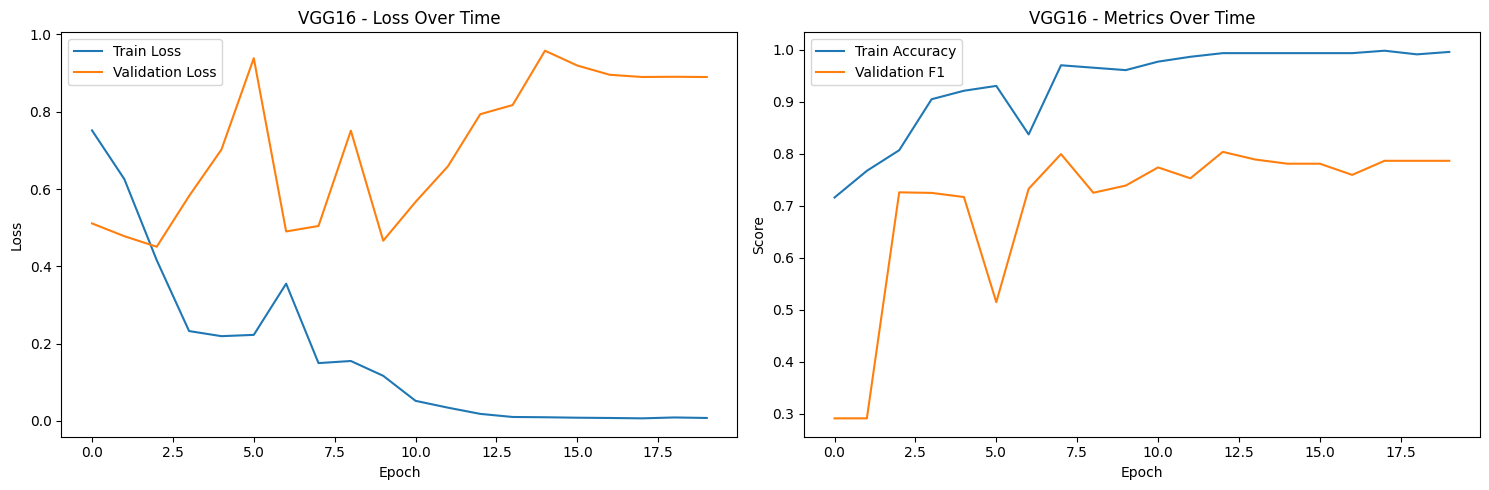

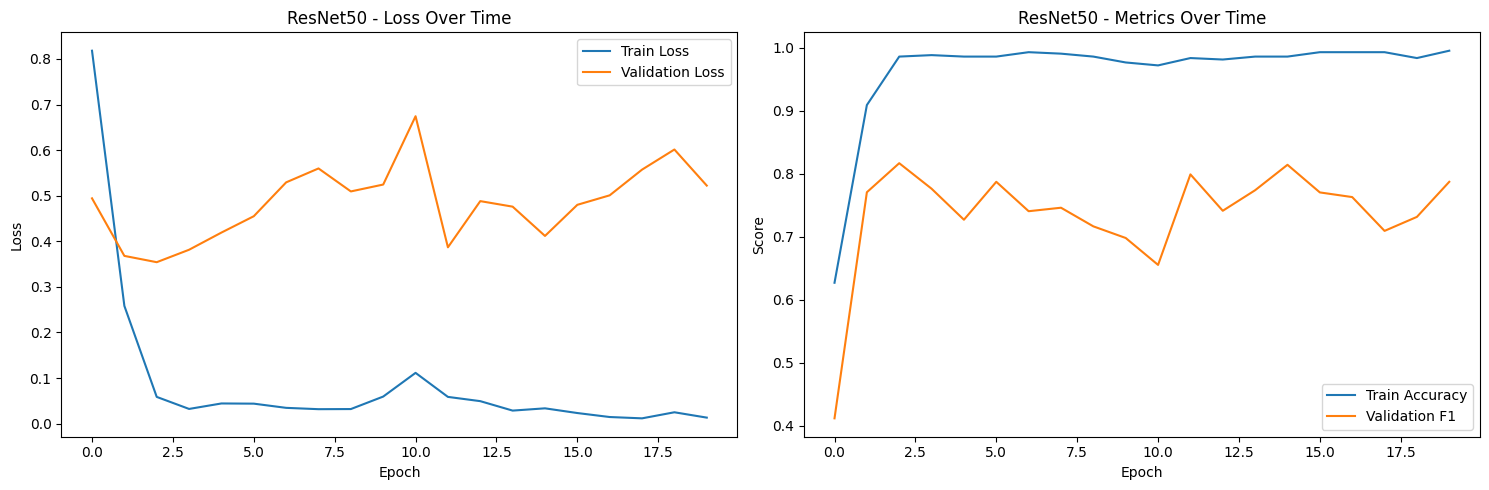

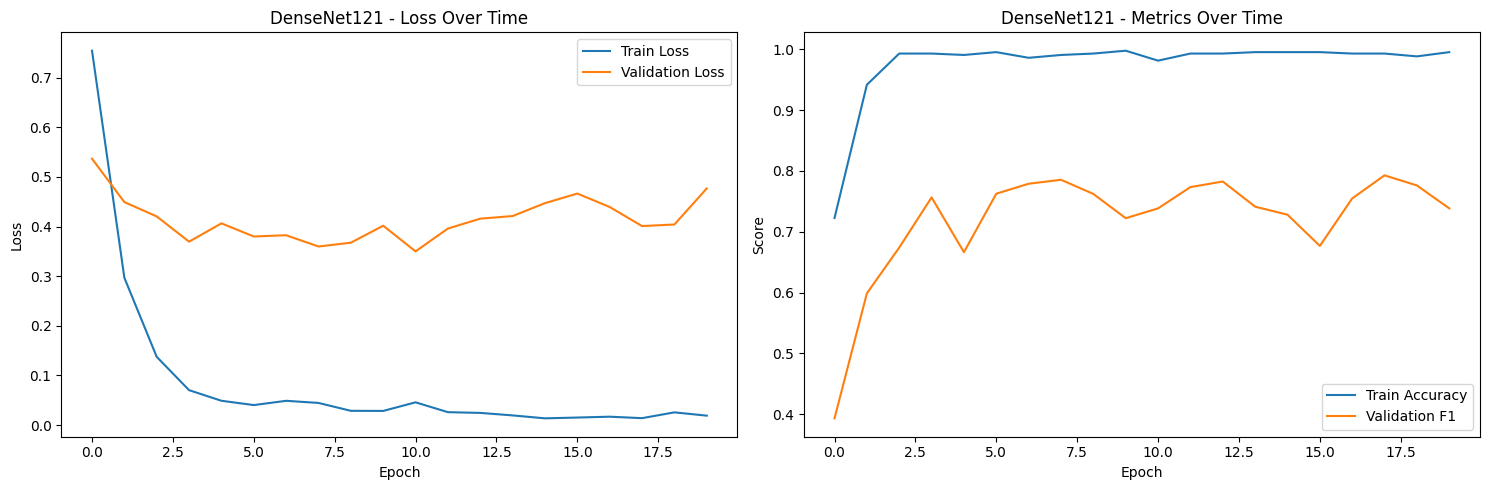

In [ ]:
def plot_training_history(history, model_name):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training loss
    ax1.plot(history['train_loss'], label='Train Loss')
    ax1.plot(history['val_loss'], label='Validation Loss')
    ax1.set_title(f'{model_name} - Loss Over Time')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Plot metrics
    ax2.plot(history['train_acc'], label='Train Accuracy')
    ax2.plot(history['val_f1'], label='Validation F1')
    ax2.set_title(f'{model_name} - Metrics Over Time')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Score')
    ax2.legend()

    plt.tight_layout()
    plt.show()

# Plot training history for each model
plot_training_history(vgg_history, 'VGG16')
plot_training_history(resnet_history, 'ResNet50')
plot_training_history(densenet_history, 'DenseNet121')

In [ ]:
# Cell 7: Ensemble Prediction and Evaluation
def ensemble_predict(inputs):
    vgg_output = trained_vgg(inputs)
    resnet_output = trained_resnet(inputs)
    densenet_output = trained_densenet(inputs)
    ensemble_output = (vgg_output + resnet_output + densenet_output) / 3
    _, preds = torch.max(ensemble_output, 1)
    return preds

# Evaluate ensemble model on test set
y_true = []
y_pred = []
with torch.no_grad():
    for inputs, labels in tqdm(test_loader, desc='Evaluating ensemble'):
        inputs = inputs.to(device)
        labels = labels.to(device)
        preds = ensemble_predict(inputs)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Calculate metrics
test_accuracy = accuracy_score(y_true, y_pred)
test_f1 = f1_score(y_true, y_pred, average='macro')
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score: {test_f1:.4f}")

Evaluating ensemble:   0%|          | 0/5 [00:00<?, ?it/s]

Test Accuracy: 0.8819
Test F1-Score: 0.8247


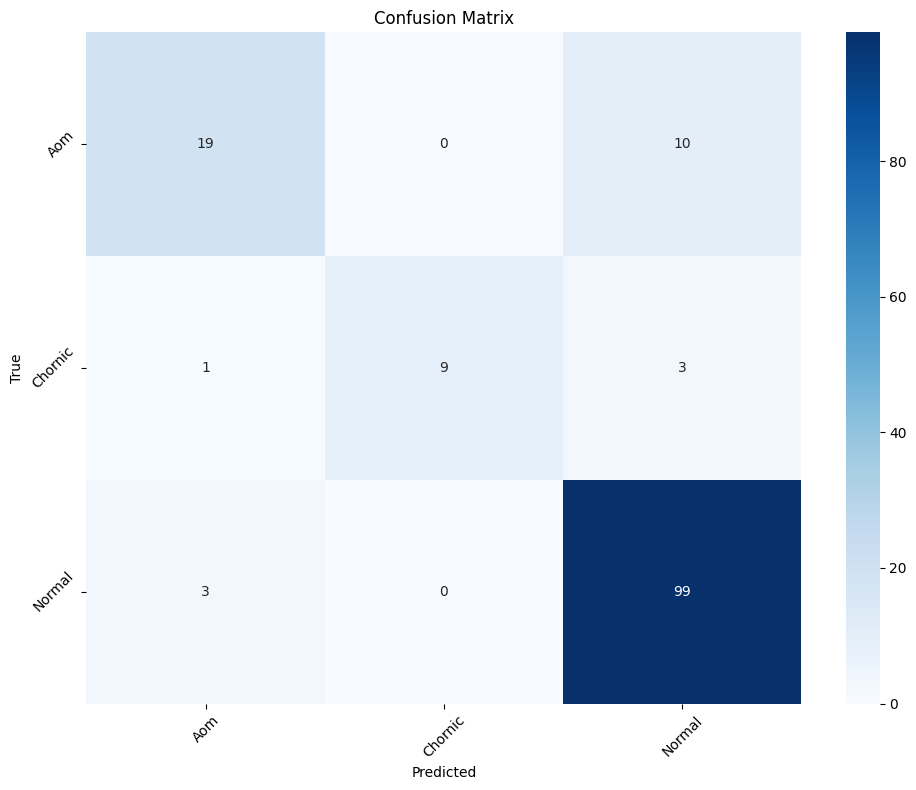

In [ ]:
# Cell 8: Confusion Matrix
plt.figure(figsize=(10, 8))
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=dataset.classes,
            yticklabels=dataset.classes)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()